In [18]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx

path = r"C:\Users\tomsc\matsim\hamburg\scenario-u5\hamburg-v3.0-10pct-base.output_trips.csv\hamburg-v3.0-10pct-base.output_trips.csv"
# Lesen der legs.csv Datei
trips_df = pd.read_csv(path, delimiter=";")

C:\Users\tomsc\AppData\Local\Temp\ipykernel_19796\1109686189.py:10: DtypeWarning: Columns (0,21,22) have mixed types. Specify dtype option on import or set low_memory=False.
  trips_df = pd.read_csv(path, delimiter=";")


# find agents that start or end with u5 (u5-walk/ walk-u5)

In [19]:
path = r"C:\Users\tomsc\matsim\hamburg\scenario-u5\hamburg-v3.0-10pct-base.output_legs.csv\hamburg-v3.0-10pct-base.output_legs.csv"
# Lesen der legs.csv Datei
data_legs = pd.read_csv(path, delimiter=";")

C:\Users\tomsc\AppData\Local\Temp\ipykernel_19796\2867423561.py:3: DtypeWarning: Columns (0,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data_legs = pd.read_csv(path, delimiter=";")


In [20]:
legs_df = data_legs
legs_df.head(3)

,person,trip_id,dep_time,trav_time,wait_time,distance,mode,start_link,start_x,start_y,end_link,end_x,end_y,access_stop_id,egress_stop_id,transit_line,transit_route,vehicle_id
0,10,10_1,09:40:53,00:02:40,00:00:00,169,walk,584925770008f,606877.292289,5.982422e+06,584925770008f,606840.859521,5.982385e+06,NaN,NaN,NaN,NaN,NaN
1,10,10_1,09:43:33,00:57:31,00:00:00,74408,car,584925770008f,606840.859521,5.982385e+06,7884380060000f,568000.854994,5.933516e+06,NaN,NaN,NaN,NaN,10
2,10,10_1,10:41:04,00:01:13,00:00:00,77,walk,7884380060000f,568000.854994,5.933516e+06,7884380060000f,567977.597178,5.933565e+06,NaN,NaN,NaN,NaN,NaN


# 1 - find u5 legs

In [21]:
# Neue Spalte mode kopieren, um hier U5 als mode einzutragen
legs_df['mode_u5'] = legs_df['mode']

# Filtern nach Legs, die den ÖPNV verwenden
pt_legs = legs_df[legs_df['mode'] == 'pt']

# Filtern nach U5-Fahrzeug-IDs in der Route
u5_legs = pt_legs[pt_legs['vehicle_id'].str.contains('AB_U5_Veh_|BA_U5_Veh_')]

# u5 als mode in Spalte mode_u5 eintragen
u5_legs['mode_u5'] = 'U5'

# overwrite legs_df at "mode_u5"
legs_df.update(u5_legs['mode_u5'], overwrite=True)

# Check the result
legs_df.head()

C:\Users\tomsc\AppData\Local\Temp\ipykernel_19796\465566448.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  u5_legs['mode_u5'] = 'U5'


,person,trip_id,dep_time,trav_time,wait_time,distance,mode,start_link,start_x,start_y,end_link,end_x,end_y,access_stop_id,egress_stop_id,transit_line,transit_route,vehicle_id,mode_u5
0,10,10_1,09:40:53,00:02:40,00:00:00,169,walk,584925770008f,606877.292289,5.982422e+06,584925770008f,606840.859521,5.982385e+06,NaN,NaN,NaN,NaN,NaN,walk
1,10,10_1,09:43:33,00:57:31,00:00:00,74408,car,584925770008f,606840.859521,5.982385e+06,7884380060000f,568000.854994,5.933516e+06,NaN,NaN,NaN,NaN,10,car
2,10,10_1,10:41:04,00:01:13,00:00:00,77,walk,7884380060000f,568000.854994,5.933516e+06,7884380060000f,567977.597178,5.933565e+06,NaN,NaN,NaN,NaN,NaN,walk
3,10,10_2,19:55:04,00:01:13,00:00:00,77,walk,7884380060000f,567977.597178,5.933565e+06,7884380060000f,568000.854994,5.933516e+06,NaN,NaN,NaN,NaN,NaN,walk
4,10,10_2,19:56:17,00:57:06,00:00:00,74696,car,7884380060000f,568000.854994,5.933516e+06,584925770008f,606840.859521,5.982385e+06,NaN,NaN,NaN,NaN,10,car


In [22]:
# get leg_id as column
legs_df['leg_id'] = legs_df.index

In [23]:
# Precompute conditions (whether the mode is 'U5' or 'walk')
legs_df['is_U5'] = legs_df['mode_u5'] == 'U5'
legs_df['is_walk'] = legs_df['mode_u5'] == 'walk'

# Identify the first, second, second-to-last, and last legs in each trip

# Get the rank of legs in the trip
legs_df['leg_rank'] = legs_df.groupby('trip_id').cumcount() + 1
legs_df['leg_count'] = legs_df.groupby('trip_id')['leg_id'].transform('count')

# Identify the first, second, second-to-last, and last legs
legs_df['is_first_leg'] = legs_df['leg_rank'] == 1
legs_df['is_second_leg'] = legs_df['leg_rank'] == 2
legs_df['is_second_last_leg'] = legs_df['leg_rank'] == (legs_df['leg_count'] - 1)
legs_df['is_last_leg'] = legs_df['leg_rank'] == legs_df['leg_count']

# Apply conditions to specific legs

# Condition for 'start': First leg is 'walk' and second leg is 'U5'
legs_df['start'] = (legs_df['is_first_leg'] & legs_df['is_walk'] & 
                    legs_df.groupby('trip_id')['mode_u5'].shift(-1).eq('U5'))

# Condition for 'end': Second-to-last leg is 'U5' and last leg is 'walk'
legs_df['end'] = (legs_df['is_second_last_leg'] & legs_df['is_U5'] & 
                  legs_df.groupby('trip_id')['mode_u5'].shift(-1).eq('walk'))

# Get unique trip_id with start and end flags
trip_summary = legs_df.groupby('trip_id').agg(
    start=('start', 'any'),  # True if any row in the trip has 'start' condition True
    end=('end', 'any')       # True if any row in the trip has 'end' condition True
).reset_index()

In [24]:
# Check the resulting trip summary with 'start' and 'end' columns
trip_summary.head(3)

,trip_id,start,end
0,100002_1,False,False
1,100002_2,False,False
2,100002_3,False,False


# merge to trips_df

In [25]:
merged_df = trips_df.merge(trip_summary, on='trip_id', how='left')

In [26]:
merged_df['start_act_type_clean'] = merged_df['start_activity_type'].str.split('_').str[0]

In [27]:
merged_df.head(3)

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,start_y,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,start,end,start_act_type_clean
0,10,1,10_1,09:40:53,01:01:24,00:00:00,74655,62452,car,car,...,5.982422e+06,NaN,7884380060000f,567977.597178,5.933565e+06,NaN,NaN,False,False,home
1,10,2,10_2,19:55:04,01:00:59,00:00:00,74944,62411,car,car,...,5.933565e+06,NaN,584925770008f,606757.185177,5.982467e+06,NaN,NaN,False,False,leisure
2,100,1,100_1,05:52:14,00:30:51,00:00:00,5811,4109,bike,bike,...,5.984601e+06,NaN,5523673040006f,601031.565952,5.985119e+06,NaN,NaN,False,False,home


In [28]:
df_u5_start = merged_df[merged_df['start'] == True]

In [29]:
df_u5_start.head()

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,start_y,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,start,end,start_act_type_clean
339,100242,4,100242_4,09:54:40,00:27:21,00:00:28,6043,4942,pt,pt,...,5.934297e+06,NaN,1438247360005f,564808.896103,5.939180e+06,BA-JungfernstiegStopFacility,BA-UKEStopFacility,True,True,errands
340,100242,5,100242_5,18:41:25,01:25:05,00:12:35,32338,21499,pt,pt,...,5.939180e+06,NaN,604181030003f,565574.622017,5.960666e+06,BA-UKEStopFacility,000000370103,True,False,work
546,10038,2,10038_2,08:28:04,00:21:49,00:00:51,1975,1130,pt,walk,...,5.936215e+06,NaN,1369654560000f,565358.873217,5.937101e+06,BA-GrindelbergStopFacility,BA-HoheluftbrueckeStopFacility,True,True,errands
547,10038,3,10038_3,08:49:53,00:21:09,00:00:11,1975,1130,pt,walk,...,5.937101e+06,NaN,2387470250010f,564656.654342,5.936215e+06,AB-HoheluftbrueckeStopFacility,AB-GrindelbergStopFacility,True,True,other
653,100459,2,100459_2,13:05:48,00:05:35,00:00:37,1267,968,pt,pt,...,5.935045e+06,NaN,491706080002f,567722.031841,5.935785e+06,AB-St_GeorgStopFacility,AB-UhlenhorstStopFacility,True,True,shop


# make the plot

In [30]:
path = r'C:\Users\tomsc\matsim\hamburg\analysis\matsim-hamburg-u5.csv'
u5_stops = pd.read_csv(path, delimiter=',')

In [31]:
gdf_u5_stops = gpd.GeoDataFrame(
    u5_stops,
    geometry=gpd.points_from_xy(u5_stops['x'], u5_stops['y']),
    crs="EPSG:25832"
)

gdf_u5_stops.head(2)

,Haltestelle,ID,x,y,isNew,Change to:,geometry
0,Bramfeld,NaN,571219,5941120,True,NaN,POINT (571219.000 5941120.000)
1,Steilshoop,NaN,570058,5940701,True,NaN,POINT (570058.000 5940701.000)


In [32]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_u5_start,
    geometry=gpd.points_from_xy(df_u5_start['start_x'], df_u5_start['start_y']),
    crs="EPSG:25832"
)

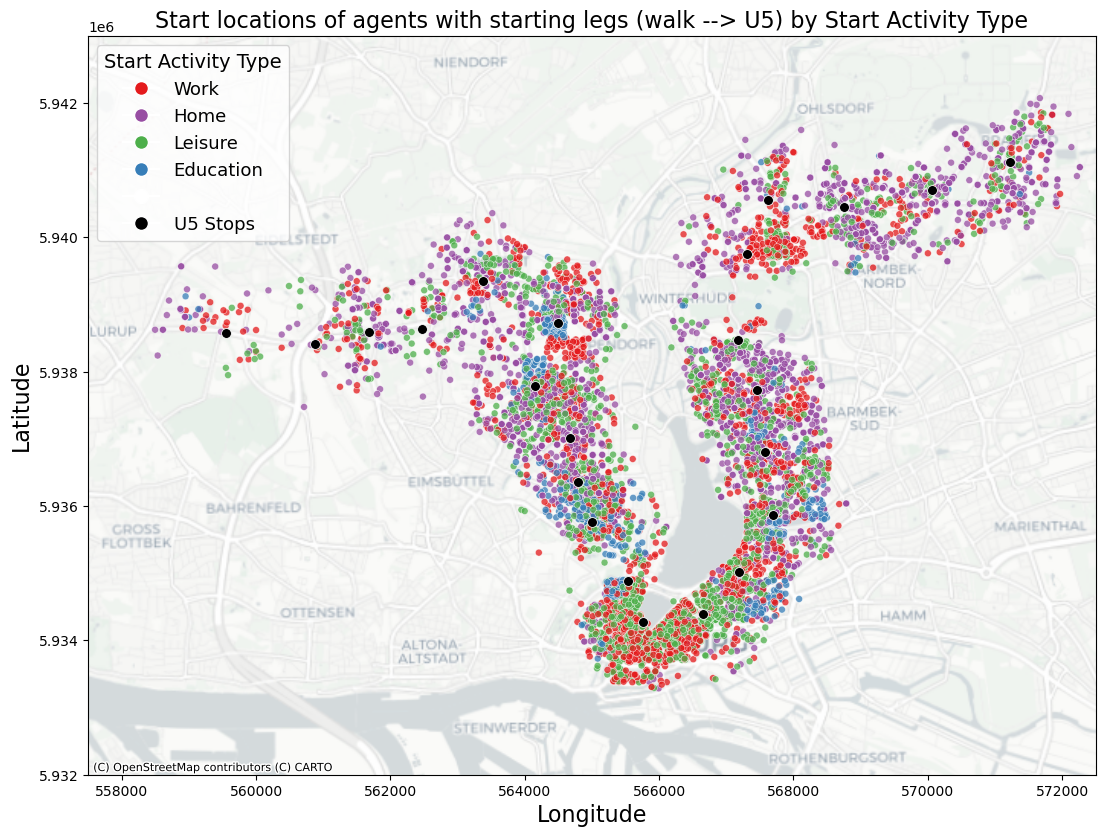

In [48]:
activities = ['work', 'home', 'leisure', 'educ']
gdf_4 = gdf[gdf['start_act_type_clean'].isin(activities)]

# Erstellen einer Farbcodierung basierend auf `start_act_type_clean`
# Verwende Seaborn, um eine Palette für die Aktivitätstypen zu erstellen
#palette = sns.color_palette("tab10", n_colors=gdf['start_act_type_clean'].nunique())
palette = sns.color_palette("Set1", n_colors=4)

# Plotten der Punkte mit Seaborn
fig, ax = plt.subplots(1, 1, figsize=(13, 13))

# Scatterplot erstellen
sns.scatterplot(data=gdf_4, x='start_x', y='start_y', hue='start_act_type_clean', palette=palette, ax=ax, s=25, alpha=0.75)
sns.scatterplot(x='x', y='y', data=u5_stops, s=50, color='black', label='U5 Stops')

# Haltestellen-Namen plotten (optional)
#for i, station in u5_stops.iterrows():
#    plt.text(station['x'] + 0.07, station['y'] + 0.07, station['Haltestelle'], fontsize=14)

# Set the plot limits to focus on the area of interest
plt.xlim(557500, 572500)
plt.ylim(5932000, 5943000)

# Set the plot limits to focus on the area of interest
#plt.xlim(480000, 630000)
#plt.ylim(5890000, 6000000)

# Create custom handles for the legend
custom_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E41A1C', markersize=10, alpha=1, label='Work'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#984EA3', markersize=10, alpha=1, label='Home'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4DAF4A', markersize=10, alpha=1, label='Leisure'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#377EB8', markersize=10, alpha=1, label='Education'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markersize=10, alpha=1, label=''),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, alpha=1, label='U5 Stops')
                  ]

# Add the custom handles to the legend
#plt.legend(handles=custom_handles, loc='upper left', fontsize=13)

legend = plt.legend(handles=custom_handles, loc='upper left', fontsize=13)

# Titel der Legende setzen
legend.set_title('Start Activity Type', prop={'size': 14})

# Titel und Achsenbeschriftungen
plt.title("Start locations of agents with starting legs (walk --> U5) by Start Activity Type", fontsize=16)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)

# Anpassen der Legende
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles, labels=labels, title="Start Activity Type", title_fontsize='13', fontsize='12', loc='lower left', markerscale=3, labelspacing=1.3)

# HIntergrund schwarz/weiß
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:25832")

# Plot anzeigen
plt.show()

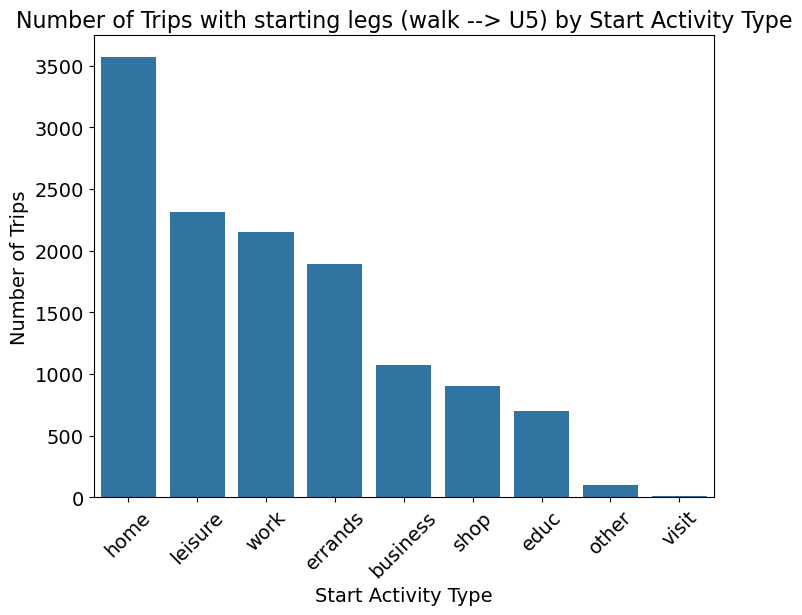

In [47]:
# Zähle die Anzahl der Trips für jeden start_act_type_clean
activity_counts = gdf['start_act_type_clean'].value_counts()

# Erstelle den Barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=activity_counts.index, y=activity_counts.values) # , palette="Set2"

# Achsenbeschriftungen und Titel hinzufügen
plt.xlabel('Start Activity Type', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.title('Number of Trips with starting legs (walk --> U5) by Start Activity Type', fontsize=16)
plt.xticks(rotation=45)  # Optional: Rotiert die x-Achsen-Beschriftungen, falls sie überlappen
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 

# Plot anzeigen
plt.show()


# find u5 end users

In [49]:
merged_df.head()

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,start_y,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,start,end,start_act_type_clean
0,10,1,10_1,09:40:53,01:01:24,00:00:00,74655,62452,car,car,...,5.982422e+06,NaN,7884380060000f,567977.597178,5.933565e+06,NaN,NaN,False,False,home
1,10,2,10_2,19:55:04,01:00:59,00:00:00,74944,62411,car,car,...,5.933565e+06,NaN,584925770008f,606757.185177,5.982467e+06,NaN,NaN,False,False,leisure
2,100,1,100_1,05:52:14,00:30:51,00:00:00,5811,4109,bike,bike,...,5.984601e+06,NaN,5523673040006f,601031.565952,5.985119e+06,NaN,NaN,False,False,home
3,100,2,100_2,15:02:18,00:30:51,00:00:00,5811,4007,bike,bike,...,5.985119e+06,NaN,2316064800006f,597059.750379,5.984586e+06,NaN,NaN,False,False,work
4,100002,1,100002_1,11:33:30,00:05:20,00:00:00,339,210,walk,walk,...,5.956417e+06,NaN,7446824860010f,565688.006149,5.956543e+06,NaN,NaN,False,False,home


In [50]:
merged_df['end_act_type_clean'] = merged_df['end_activity_type'].str.split('_').str[0]

In [51]:
df_u5_end = merged_df[merged_df['end'] == True]
df_u5_end.head(4)

,person,trip_number,trip_id,dep_time,trav_time,wait_time,traveled_distance,euclidean_distance,main_mode,longest_distance_mode,...,end_facility_id,end_link,end_x,end_y,first_pt_boarding_stop,last_pt_egress_stop,start,end,start_act_type_clean,end_act_type_clean
339,100242,4,100242_4,09:54:40,00:27:21,00:00:28,6043,4942,pt,pt,...,NaN,1438247360005f,564808.896103,5.939180e+06,BA-JungfernstiegStopFacility,BA-UKEStopFacility,True,True,errands,work
546,10038,2,10038_2,08:28:04,00:21:49,00:00:51,1975,1130,pt,walk,...,NaN,1369654560000f,565358.873217,5.937101e+06,BA-GrindelbergStopFacility,BA-HoheluftbrueckeStopFacility,True,True,errands,other
547,10038,3,10038_3,08:49:53,00:21:09,00:00:11,1975,1130,pt,walk,...,NaN,2387470250010f,564656.654342,5.936215e+06,AB-HoheluftbrueckeStopFacility,AB-GrindelbergStopFacility,True,True,other,errands
652,100459,1,100459_1,11:14:15,01:04:56,00:11:16,26960,23466,pt,pt,...,NaN,829320090003f,567098.766949,5.935045e+06,000008007052.1,BA-St_GeorgStopFacility,False,True,home,shop


In [52]:
# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df_u5_end,
    geometry=gpd.points_from_xy(df_u5_end['end_x'], df_u5_end['end_y']),
    crs="EPSG:25832"
)

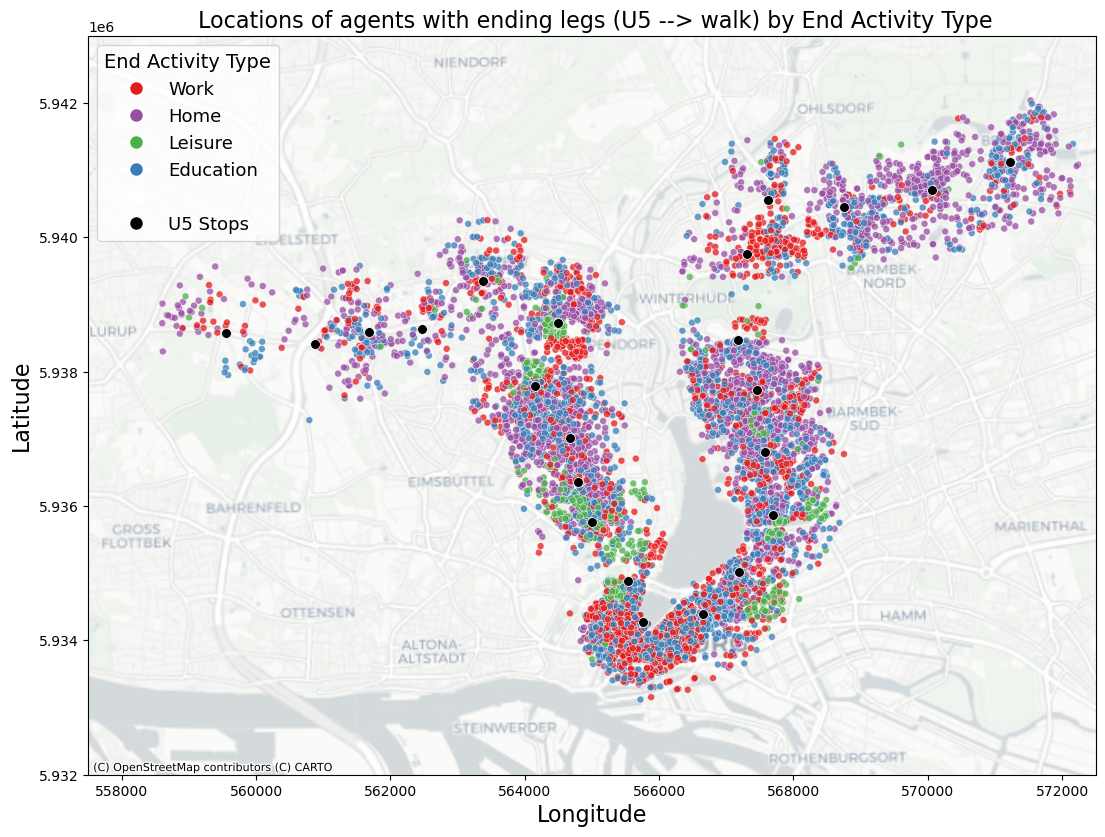

In [54]:
activities = ['work', 'home', 'leisure', 'educ']
gdf_4 = gdf[gdf['end_act_type_clean'].isin(activities)]

# Erstellen einer Farbcodierung basierend auf `start_act_type_clean`
# Verwende Seaborn, um eine Palette für die Aktivitätstypen zu erstellen
#palette = sns.color_palette("tab10", n_colors=gdf['start_act_type_clean'].nunique())
palette = sns.color_palette("Set1", n_colors=4)

# Plotten der Punkte mit Seaborn
fig, ax = plt.subplots(1, 1, figsize=(13, 13))

# Scatterplot erstellen
sns.scatterplot(data=gdf_4, x='end_x', y='end_y', hue='end_act_type_clean', palette=palette, ax=ax, s=25, alpha=0.75)
sns.scatterplot(x='x', y='y', data=u5_stops, s=50, color='black', label='U5 Stops')

# Haltestellen-Namen plotten (optional)
#for i, station in u5_stops.iterrows():
#    plt.text(station['x'] + 0.07, station['y'] + 0.07, station['Haltestelle'], fontsize=14)

# Set the plot limits to focus on the area of interest
plt.xlim(557500, 572500)
plt.ylim(5932000, 5943000)

# Set the plot limits to focus on the area of interest
#plt.xlim(480000, 630000)
#plt.ylim(5890000, 6000000)

# Create custom handles for the legend
custom_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#E41A1C', markersize=10, alpha=1, label='Work'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#984EA3', markersize=10, alpha=1, label='Home'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4DAF4A', markersize=10, alpha=1, label='Leisure'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#377EB8', markersize=10, alpha=1, label='Education'),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white', markersize=10, alpha=1, label=''),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, alpha=1, label='U5 Stops')
                  ]

# Add the custom handles to the legend
#plt.legend(handles=custom_handles, loc='upper left', fontsize=13)

legend = plt.legend(handles=custom_handles, loc='upper left', fontsize=13)

# Titel der Legende setzen
legend.set_title('End Activity Type', prop={'size': 14})

# Titel und Achsenbeschriftungen
plt.title(" Locations of agents with ending legs (U5 --> walk) by End Activity Type", fontsize=16)
plt.xlabel("Longitude", fontsize=16)
plt.ylabel("Latitude", fontsize=16)

# Anpassen der Legende
#handles, labels = ax.get_legend_handles_labels()
#ax.legend(handles=handles, labels=labels, title="End Activity Type", title_fontsize='13', fontsize='12', loc='center right', markerscale=3, labelspacing=1.6, bbox_to_anchor=(1.2,.85))

# HIntergrund schwarz/weiß
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs="EPSG:25832")

# Plot anzeigen
plt.show()

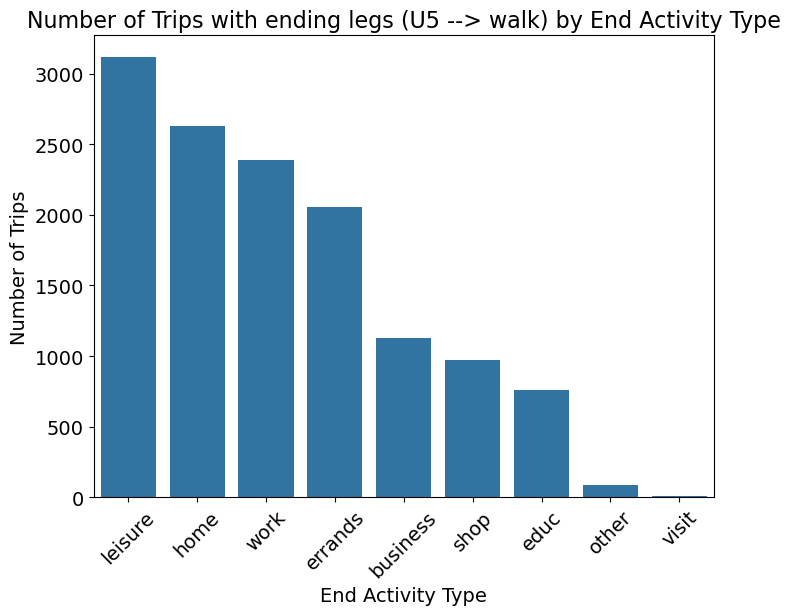

In [62]:
# Zähle die Anzahl der Trips für jeden start_act_type_clean
activity_counts = gdf['end_act_type_clean'].value_counts()

# Erstelle den Barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=activity_counts.index, y=activity_counts.values) # , palette="Set2"

# Achsenbeschriftungen und Titel hinzufügen
plt.xlabel('End Activity Type', fontsize=14)
plt.ylabel('Number of Trips', fontsize=14)
plt.title('Number of Trips with ending legs (U5 --> walk) by End Activity Type', fontsize=16)
plt.xticks(rotation=45)  # Optional: Rotiert die x-Achsen-Beschriftungen, falls sie überlappen
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 

# Plot anzeigen
plt.show()
